In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import seaborn as sns 

In [144]:
MAX_FLOAT_SIZE = 2e32-1

## Objectif

Dans ce projet on souhaite mettre en oeuvre une méthode pour estimer les paramètres d’une fonction
linéaire. Pour cela on on suppose avoir accès à des observations bruitées de cette fonction. En introduisant un modèle de bruit Gaussien, on étudie les propriétés de cet estimateur. Notamment, on montre
la convergence (dans un sens que l’on précisera) de cet estimateur.

## Préliminaires

Soit $\beta_0$ , $\beta_1$ $\in \mathbb{R}$. On considère une fonction $Y: [0,1] \rightarrow{} \mathbb{R}$ telle que pour tout $x \in [0,1]$,

$$
    Y(x) = \beta_0 + \beta_1 x
$$

On suppose que $\beta_0, \ \beta_1$ sont des paramètres inconnus que l’ont souhaite estimer à partir d’observation
de la fonction $Y$ en $n$ points distincts $(x_1, \ \dots, \ x_n)$, avec $n \in \mathbb{N}$. On supposera que l’on observe la
fonction $Y$ en ces points mais que ces observation sont bruitées. En particulier le practicien observe
des réalisations de

$$
    Y_{obs}(x_i) = Y(x_i) + \epsilon_i , i \in \{1, \ \dots, \ n\},
$$

où  $(\epsilon_i)_{i \in \mathrm{N}}$ est une suite de variable aléatoire $i.i.d.$ suivant la loi normale centrée de variance $\sigma^2$ avec $\sigma >0$.

## Résolution du problème des moindres carrés

**S1.** Proposer et implémenter un algorithme de simulation de $Y_{obs}^{n} := (Y_{obs}(x_1), \dots, Y_{obs}(x_n))$ lorsque les $(x_1, \dots, x_n)$ sont choisis de façon uniforme sur $[0,1]$.

In [145]:
class LinearRegressionSimulator:
    def __init__(
            self, 
            beta: np.ndarray, 
            sigma: float,
        ) -> None:
        self.__beta = beta

        if (sigma < 0):
            raise AttributeError("sigma must be non negative")
        self.__sigma = sigma
        
    def simulate(
            self,
            n_obs : int
        ) -> np.ndarray:
        epsilon : np.ndarray = np.\
            random\
            .normal(0, self.__sigma, n_obs)
        
        x = np.array([k for k in np.linspace(0, 1, num= n_obs)])
                
        x = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )
        
        return x @ self.__beta + epsilon
    
    @staticmethod
    def get_x(n_obs : int) -> np.ndarray:
        return np.array([k for k in np.linspace(0, 1, num= n_obs)])
    
    
    def get_X(self, n_obs : int) -> np.ndarray:
        x= self.get_x(n_obs)

        X = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )

        return X

         
    def get_y(self, n_obs: int) -> np.ndarray:
        x = self.get_x(n_obs)

        x = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )

        return x @ self.__beta



In [146]:
# these values are arbitrary
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [147]:
lin_reg_simulator = LinearRegressionSimulator(
    beta,
    sigma
)

In [148]:
x = lin_reg_simulator.get_x(n_obs)
y_obs = lin_reg_simulator.simulate(n_obs)

In [149]:
x

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [150]:
y_obs

array([1.24957348, 1.20955101, 1.18093941, 1.36859911, 1.36999052,
       1.58570569, 1.45827804, 1.68158701, 1.9481881 , 1.87800021,
       2.13704679, 2.23324534, 2.18080935, 2.38772492, 2.38609361,
       2.5109113 , 2.69865163, 2.64153589, 2.75656197, 2.86065526])

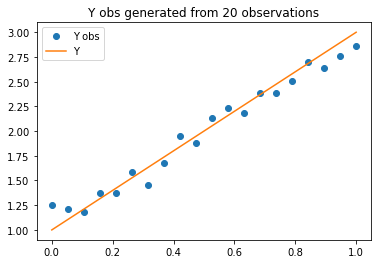

In [151]:
plt.plot(
    x, 
    y_obs, 
    'o',
    label = "Y obs"
)
plt.plot(
    x, 
    lin_reg_simulator.get_y(n_obs),
    label="Y"
)
plt.title(f"Y obs generated from {n_obs} observations")
plt.legend()

**T1.** Écrire le problème sous la forme

$$
    Y^n = X^n \beta
$$

où $Y^n = (Y(x_1), \dots, Y(x_n))^T \in \mathbb{R^n}$. On précisera $X^n$ et $\beta$.

Comme on a déjà fait dans l'exercice **S1**, il suffit de prendre : 

$$
    X^n = 
        \begin{pmatrix}
            1 & x_1\\
            1 & x_2 \\
            \vdots & \vdots \\
            1 & x_n
        \end{pmatrix}, \

    \beta = \
        \begin{pmatrix}
            \beta_0 \\
            \beta_1
        \end{pmatrix}
$$

On admet maintenant que $(X^n)^T$ est inversible où $(X^n)^T$ est la transposé de la matrice $(X^n)$. On s'intéresse à l'estimateur des moindres carrés de $\beta$ que l'on note $\hat{\beta}^n$ et qui est défini par 

$$
    \hat{\beta^n} := \underset{\beta \in \mathbb{R^2}}{\operatorname{arg \ min}} || Y_{obs}^n - X^n \beta || ^2
$$

où $||.||$ est la norme euclidienne dans $\mathbb{R}^n$. On peut montrer que cette solution maximise la densité de $Y_{obs}^n$.

**T2.** Montrer que $\hat{\beta}^n = ((X^n)^T X^n)^{-1}(X^n)^T Y_{obs}^n$ 

On va écrire l'erreur quadratique et, **pour simplifier, on va employer la notation $X^n = X$ et $Y_{obs}^n = Y_{obs}$**:

$$
    \begin{aligned}
    E(\beta) & = || (Y_{obs}- X\beta) ||^2 \\
             & = (Y_{obs}- X \beta)^T(Y_{obs} - X \beta) \\
             & = Y_{obs}^T Y_{obs} - 2 Y_{obs}^T X \beta + \beta ^T X ^T X \beta
    \end{aligned}
$$

Il faut que $\frac{d E(\beta)}{d \beta} = 0$. Alors, on a:

$$
    2 \beta^T X^T X - 2 Y_{obs}^T X = 0 \\

    \beta ^T X^T X = Y_{obs}^T X \\

    X^T X \beta = X^T Y_{obs}
$$

Donc on trouve le résultat:

$$
    \hat{\beta}^n = (X^T X)^{-1} X^T Y_{obs}
$$

**T3** Quelle est la loi de $\hat{\beta}^n$? En déduire que $\mathbb{E}[\hat{\beta^n}] = \beta$. On dit que l'estimateur $\hat{\beta}^n$ est non biaisé.

**Pour simplifier la notation, on va utiliser $\hat{\beta^n} = \hat{\beta}$**

En sachant que les $(\varepsilon_i)_{i \leq n}$ sont *i.i.d*, le vecteur d'erreurs $\varepsilon = (\varepsilon_i)_{i \leq n}$ une loi normale de moyenne $0_{n}$ et matrice de covariance $\sigma^2 I_{n}$

$$
    \varepsilon \sim \mathcal{N}(0_{n}, \ \sigma^2 I_{n})  \\

    Y_{obs} = X \beta + \varepsilon \Rightarrow 

    Y_{obs} \sim \mathcal{N}(X \beta, \sigma^2 I_{n})
$$

Alors:

$$
    \hat{\beta} = (X^T X)^{-1} X^T Y_{obs} \Rightarrow \hat{\beta} \sim \mathcal{N} (A X\beta, \sigma^2 A A^T)
$$

où $A = (X^T X)^{-1} X^T$. On sait que 
$$
\begin{aligned}
    AX & = (X^T X)^{-1} X^T X \\
       & = I_{n}
\end{aligned}
$$

et 

$$
\begin{aligned}
    A A^T & = (X^T X)^{-1}X^T X (X^T X)^{-1} \\
          & = (X^T X)^{-1}
\end{aligned}
$$

Alors, on conclut que $ \hat{\beta} \sim \mathcal{N} (\beta, \sigma^2 (X^T X)^{-1}) $

**T4** Montrer que $\frac{1}{\sigma} (\hat{\beta^n} - \beta)^T((X^n)^T X^n) (\hat{\beta}^n -\beta)$ suit une loi $\chi _2^2$ (chi2 à 2 d'grés de libertés). On note $q^{\chi _2^2}(r)$ le quantile de la loi du $\chi _2 ^2$ à l'ordre $r$ et pour $\alpha \in [0,1]$, on définit:


$$
    \varepsilon_{\alpha, n} \vcentcolon= \left\{  \tilde{\beta} \in \mathbb{R}^2  \frac{1}{\sigma} (\hat{\beta^n} - \beta)^T((X^n)^T X^n) (\hat{\beta}^n -\beta) \leq q^{\chi _2 ^2} (1- \alpha) \right\}
$$

Montrer que $\mathbb{P} ( \beta \in \varepsilon_{\alpha, n}) = 1- \alpha$. On appelle $\varepsilon_{\alpha, n}$ l'ellipsoîde de confiance à l'ordre $\alpha$

On a montré que $\hat{\beta} \sim \mathcal{N}(\beta, \sigma^2 (X^T X)^{-1})$

D'après les theorèmes du cours, cela implique que

$$
    \frac{1}{\sigma}(X^T X) ^{1/2} (\hat{\beta} - \beta) \sim \mathcal{N}(0, I)
$$

C'est à dire, chaque composante de $ (X^T X) ^{1/2} (\hat{\beta} - \beta) $ est une normale centrée reduite indépendante. De plus, $X^T X$ est symmetrique et positive definie, donc $((X^T X)^{1/2})^T =(X^T X)^{1/2} $

Alors, comme nous sommes en dimension 2, la norme de ce vecteur gaussien suit une loi $\chi_2^2$. En écrivant $||v|| = v^T v $:

$$
    \frac{1}{\sigma^2} (\hat{\beta} - \beta)^T (X^T X) (\hat{\beta} - \beta) \sim \chi_2^2
$$

Par la **Proposition 10.3.3** du livre du cours, avec le résultat trouvé on a que :

$$
    \mathbb{P} \left(\frac{1}{\sigma^2} (\hat{\beta} - \beta)^T (X^T X) (\hat{\beta} - \beta) \leq q^{\chi_2^2}_{1-\alpha} \right) = 1- \alpha 
$$

**S2.** Proposer et implémenter un algorithme pour représenter l'ellipsoide de confiance et pour la verification du résultat précédent pour $\alpha = 0.05%$, $\sigma = 0.1$ et $\beta = (0,1), (1,0), (1,2)$. Réitérer l'experience en faisant varier le nombre de points d'observation $n$. Que constatez vous?

In [181]:
class LinearRegression:
    def __init__(self) -> None:
        self.coef_ = None
        self.squared_error = None

    def fit(
        self, 
        X : np.ndarray, 
        y : np.ndarray
    ):
        self.coef_ = np.linalg.inv(X.T @ X) @ X.T @ y
        self.squared_error = np.linalg.norm(y - X @ self.coef_)**2

    def predict(
        self,
        X: np.ndarray
    )-> np.ndarray:
        
        if self.coef_ is None:
            raise ValueError("You must run LinearRegression.fit before predicting")
        return X @ self.coef_


In [153]:
def confidence_ellipsoid(
    alpha : float,
    beta: np.ndarray,
    sigma : int = 0.1,
    n_obs : int = 20, 
    n_points_simulation = 100000,
    search_range = 0.2
):
    """Plots the alpha confidence ellipsoid of beta_n obtained 
    from n different points

    Args:
        alpha (float): _description_
        beta (np.ndarray): _description_
        sigma (int, optional): _description_. Defaults to 0.1.
        n_obs (int, optional): _description_. Defaults to 20.
        n_points_simulation (int, optional): _description_. Defaults to 100000.
    """    
    sigma = 0.1
    lin_reg_simulator = LinearRegressionSimulator(beta, sigma)
    model = LinearRegression()

    X = lin_reg_simulator.get_X(n_obs)
    y = lin_reg_simulator.simulate(n_obs)

    model.fit(X, y)
    beta_n = model.coef_

    x_conf = []
    y_conf = []
    for i in range(n_points_simulation):
        beta_tilde_0 = np\
            .random\
            .uniform(
                beta[0] - search_range, beta[0]+ search_range
            )
        beta_tilde_1 = np.\
            random\
            .uniform(
                beta[1]-search_range, beta[1] + search_range
            )

        beta_tilde = np.array([beta_tilde_0, beta_tilde_1])
        q_1_minus_alpha = chi2.ppf(1-alpha, df = 2)
        v = 1/(sigma**2) * (beta_n-beta_tilde).T @ (X.T @ X) @ (beta_n-beta_tilde)

        if v <= q_1_minus_alpha:
            x_conf.append(beta_tilde[0])
            y_conf.append(beta_tilde[1])

    plt.plot(
        x_conf,
        y_conf,
        '.',
        
    )
    plt.title(
        r"$\frac{1}{\sigma^2} (\hat{\beta} - \beta)^T (X^T X) (\hat{\beta} - \beta) \leq q_{1-a}^{\chi_2^2}$" + 
        fr"""
        {int(100*alpha)}% - Confidence ellipsoid for $\beta = ({beta[0]}, {beta[1]})$
        $n = {n_obs}, \sigma = {sigma}$
        """)
    plt.xlabel(r"$\beta_0$")
    plt.ylabel(r"$\beta_1$")

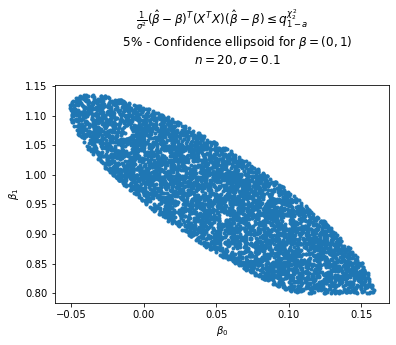

In [154]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([0,1]) , 
    sigma = 0.1, 
    n_points_simulation=30000
)



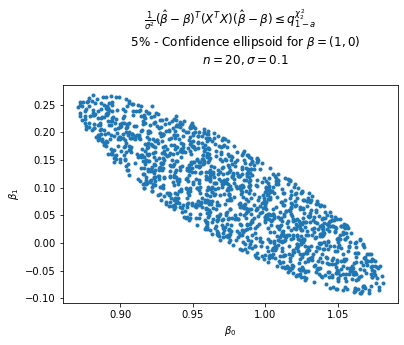

In [155]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,0]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    search_range=0.4
)

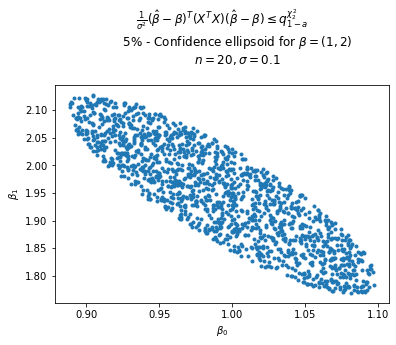

In [156]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,2]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    search_range=0.4
)

Lorsque on augmente le nombre de points dans notre regression lineaire, $\hat{\beta^n}$ s'approche de $\beta$, ce qui fait que l'ellipsoid soit moins écarté.

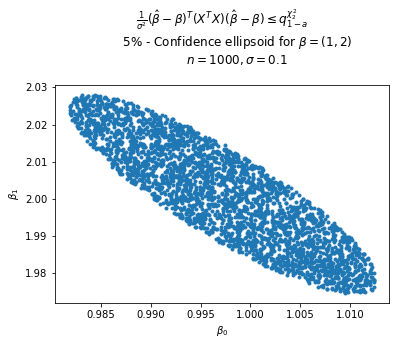

In [157]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,2]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    n_obs= 1000,
    search_range = 0.04
)


Lorsqu'on diminuit le nombre de points dans la regréssion, on observe l'effet contraire et l'ellipsoid s'écart.

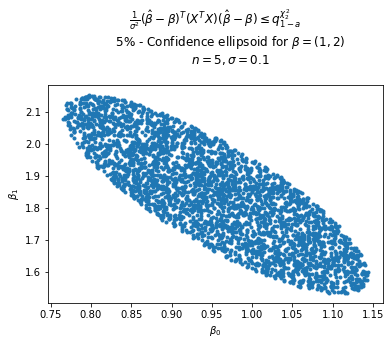

In [158]:
confidence_ellipsoid(
    alpha = 0.05,
    beta = np.array([1,2]) , 
    sigma = 0.1, 
    n_points_simulation=30000,
    n_obs= 5,
    search_range= 0.5
)

## Convergence de l'estimateur

On se propose maitenant de vérifier que $\hat{\beta^n}$ converge (dans un sens que l'on précisera) vers $\beta$. On commence par modifier la façon de choisir les $(x_1, \dots, x_n)$ afin de pouvoir réutiliser ces points lorsqu'on modifie $n$. On va introduire la suite $(x_i)_{i \in \mathrm{N}}$ de variables aléatoires *i.i.d.* suivant la loi uniforme sur $[0,1]$ et on conservera la notation $X^n$ pour la matrice construite à partir des $n$ premiers points d'observation $(x_1, \dots, x_n) $. On admet que pour tout $n \in \mathrm{N}$, $(X^n)^T X^n$ est presque sûrement inversible.

**S3** Proposer et implémenter un algorithme de simulation des éléments de la suite

$$
    (Y_{obs}^n)_{n \in \mathrm{N}} := (Y_{obs}(x_1), \dots, Y_{obs}^n (x_n))_{n \in \mathrm{N}}
$$

In [159]:
class UniformLinearRegressionSimulator:
    def __init__(
            self, 
            beta: np.ndarray, 
            sigma: float,
        ) -> None:
        self.__beta = beta
        self.__x = np.array([])

        if (sigma < 0):
            raise AttributeError("sigma must be non negative")
        self.__sigma = sigma
        
    def simulate(
            self,
            n_obs : int
        ) -> np.ndarray:
        epsilon : np.ndarray = np.\
            random\
            .normal(0, self.__sigma, n_obs)
        
        self.__x = np.random.uniform(0,1, n_obs)
                
        self.__x = np.insert(
            self.__x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )
        
        return self.__x @ self.__beta + epsilon
    
    def get_x(self, only_points : bool = False):
        if only_points:
            return self.__x[:,1]
        return self.__x
    
    def get_y(self):
        return self.__x @ self.__beta

In [160]:
# these values are arbitrary
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [161]:
unif_lin_reg_simulator = UniformLinearRegressionSimulator(
    beta,
    sigma
)

In [162]:
y_obs = unif_lin_reg_simulator.simulate(n_obs)
x = unif_lin_reg_simulator.get_x(only_points= True)

In [163]:
y_obs

array([2.19860647, 2.68964776, 1.5021071 , 2.30452497, 2.64328043,
       1.75823909, 1.3109923 , 1.29065234, 1.29270638, 1.02841752,
       2.70137619, 1.35245833, 2.24439609, 2.36551935, 2.25203053,
       2.098188  , 1.63632186, 1.64107136, 2.08181289, 2.27779235])

In [164]:
unif_lin_reg_simulator.get_y()

array([2.17863348, 2.63980106, 1.80071966, 2.23289016, 2.69734649,
       1.693656  , 1.25279324, 1.31137244, 1.15425083, 1.09131075,
       2.74791559, 1.2594955 , 2.1195627 , 2.21971232, 2.26620573,
       2.08017908, 1.649529  , 1.43296752, 2.10341003, 2.29386988])

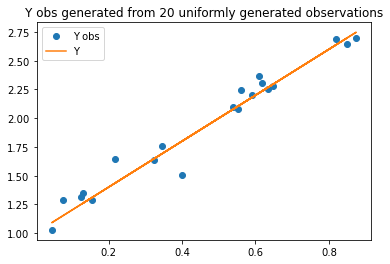

In [165]:
plt.plot(
    x, 
    y_obs, 
    'o',
    label = "Y obs"
)
plt.plot(
    x, 
    unif_lin_reg_simulator.get_y(),
    label="Y"
)
plt.title(f"Y obs generated from {n_obs} uniformly generated observations")
plt.legend()

**T5.** Montrer que presque surement:

$$
    \lim_{n \rarr \infty} \frac{1}{n} (X^n)^T X^n = 
        \begin{pmatrix}
            1 & 1/2\\
            1/2 & 1/3
        \end{pmatrix}. \
    
$$

En deduire que 

$$
    \mathbb{P} \left( \lim_{n \rarr \infty} \hat{\beta^n} = \beta \right) = 1
$$

On sait que 

$$
\begin{aligned}
    \lim_{n \rarr \infty} \frac{1}{n} (X^n)^T X^n & = 
    \lim_{n \rarr \infty} \frac{1}{n} 
    \begin{pmatrix}
        1 & \dots & 1 \\
        x_1 & \dots & x_n
    \end{pmatrix}

    \begin{pmatrix}
        1 & x_1 \\
        \vdots & \vdots \\
        1 & x_n 
    \end{pmatrix} \\
    
    & = \lim_{n \rarr \infty} \frac{1}{n} 
    \begin{pmatrix}
        n & \sum x_i \\
        \sum x_i & \sum x_i^2
    \end{pmatrix} \\

    & = 
    \begin{pmatrix}
        1 & \mathbb{E}(X_1) \\
        \mathbb{E}(X_1) & \mathbb{E}(X_1^2)
    \end{pmatrix}
\end{aligned}
$$

Comme $X_1 \sim \mathcal{U}(0,1)$, $\mathbb{E}(X_1) = 1/2, \ \mathbb{E}(X_1^2) = Var(X_1) + \mathbb{E}(X_1)^2 = 1/3$. Alors

$$
    \lim_{n \rarr \infty} \frac{1}{n} (X^n)^T X^n = 
    \begin{pmatrix}
        1 & 1/2 \\
        1/2 & 1/3
    \end{pmatrix}
$$

presque sûrement. On appelle $X^*$ cette matrice.

Comme on a montré dans l'item **T2**, 

$$
    \hat{\beta^n} =  ((X^n)^T X^n)^{-1} (X^n)^T Y_{obs}
$$

Où, $Y_{obs} = X^n \beta + \varepsilon $

Alors; 

$$
    \hat{\beta^n} =  
    \left(\frac{1}{n}(X^n)^T X^n \right)^{-1} \left(\frac{1}{n}
    (X^n)^T  (X^n \beta + \varepsilon) \right)
$$

Et, on a demontré que 

$$
    \left(\frac{1}{n}(X^n)^T X^n \right)^{-1} \rarr^{p.s.} (X^*)^{-1} \\
     \left(\frac{1}{n}(X^n)^T (X^n \beta + \varepsilon) \right) \rarr^{p.s.} X^* \beta
$$

car $X^*$ est inversible.

Alors, $\hat{\beta^n} \rarr^{p.s.} \beta$.

**S4.** Vérifier numériquement cette convergence. 

On va choisir $\beta$ arbitraire, supposons $\beta = \
        \begin{pmatrix}
            1 \\
            2
        \end{pmatrix}$.
 Alors, on a $\beta_0 = 1$ et $\beta_1 = 2$:

In [166]:
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [167]:
abs_error = []
beta_0 = []
beta_1 = []

for n_obs in range(1,1000):
    y_obs_unif = unif_lin_reg_simulator.simulate(n_obs)
    x_unif = unif_lin_reg_simulator.get_x()

    model = LinearRegression()
    model.fit(x_unif, y_obs_unif)

    abs_error.append(np.linalg.norm(model.coef_ - beta, np.inf))
    beta_0.append(model.coef_[0])
    beta_1.append(model.coef_[1])

On a la convergence des estimateurs vers les valeurs de $\beta_0$ et $\beta_1$:

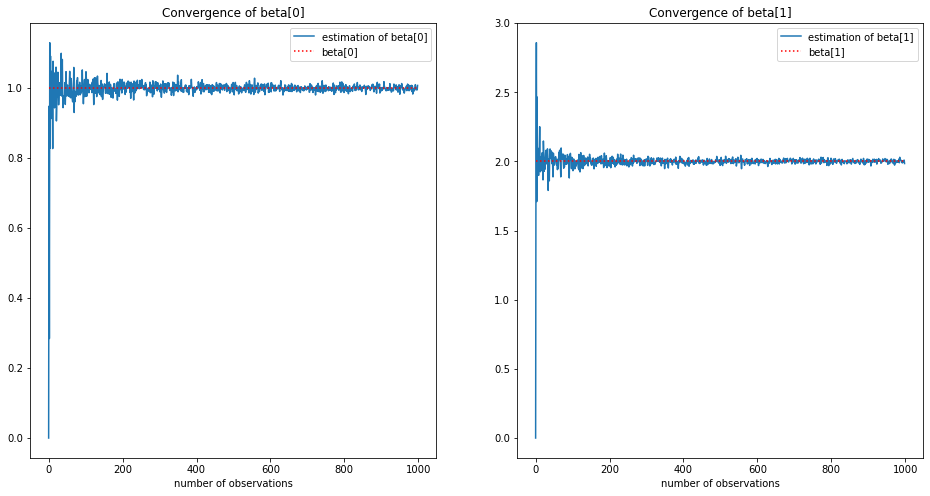

In [168]:
f, (ax1, ax2 ) = plt.subplots(1,2,)
f.set_figwidth(16)
f.set_figheight(8)

ax1.plot(
    beta_0,
    label= "estimation of beta[0]"
)

ax1.plot(
    [beta[0] for i in range(len(beta_0))],
    label = "beta[0]",
    linestyle = 'dotted',
    color = 'red'
)

ax1.set_xlabel("number of observations")
ax1.set_title("Convergence of beta[0]")
ax1.legend()

ax2.plot(
    beta_1,
    label= "estimation of beta[1]",
    # color= 'red'
)

ax2.plot(
    [beta[1] for i in range(len(beta_1))],
    label = "beta[1]",
    linestyle = 'dotted',
    color = 'red'
)

ax2.set_xlabel("number of observations")
ax2.set_title("Convergence of beta[1]")
ax2.legend()

L'erreur des estimateurs tend vers zero avec plus d'observations:

Text(0.5, 0, 'number of observations')

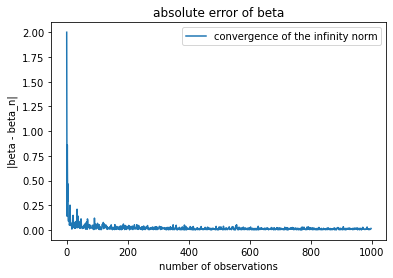

In [169]:
plt.plot(
    abs_error,
    label = "convergence of the infinity norm"
)
plt.title("absolute error of beta")
plt.legend()
plt.ylabel("|beta - beta_n|")
plt.xlabel("number of observations")

**Calcul récursif des $\hat{\beta^n}$.** La méthode décrite jusqu'à maintenant nécessite d'inverser la matrice $(X^n)^T X^n$ pour chaque $n$. On se propose maintenant de construire l'inverse de cette matrice de façon récursive. On rappele la formule de *Woodbury*: Si $A \in \mathbb{R}^{n \times n}, \ U \in \mathbb{R}^{n \times m}, \ C \in \mathbb{R}^{m \times m}, \ V \in \mathbb{R}^{m \times n}$ sont des matrices telles que $A, \ C$ et $C^{-1} + V A^{-1} U$ sont inversibles, alors $A + UCV$ est inversible et

$$
    (A + UCV )^{-1} = A^{-1} - A^{-1}U (C^{-1} + VA^{-1}U)^{-1}VA^{-1}
$$

**T6** En utilisant la formule de *Woodbury*, montrer qu'on a la relation de récurrence

$$
    ((X^{n+1})^T X^{n+1})^{-1} = ((X^n) X^n)^{-1} - \frac{1}{\alpha} v v^T
$$

où $\alpha > 0$ et $v \in \mathbb{R}^2$ sont à identifier.

On va utiliser la formule de *Woodburry* avec $A = I_n$, $C = I_n$, $U = a$ et $V = b^T$ où $a, b \in \mathbb{R}^2$:

$$
\begin{aligned}
    (I + a b^T)^{-1} & = I - I a ( I + b^T a I)^{-1} b^T I \\
                & =  I - \frac{a b^T}{( 1 + b^T a )} \\
                & = I - \frac{a b^T}{( 1 + b^T a)} 
\end{aligned}
$$

Si on multiplie par $A^{-1}$ à droite les deux cotês de l'égalité et appellons $c = A a $:

$$
\begin{aligned}
    (I + a b^T)^{-1} A^{-1} & = \left( I - \frac{a b^T}{( 1 + a b^T)} \right) A^{-1} \\
    (A + c b^T)^{-1} & = A^{-1} - \frac{A^{-1}c b^T}{( 1 + b^T A^{-1} c )} A ^{-1} \\

\end{aligned}
$$

Dans le contexte de la question, on a que:

$$
\begin{aligned}
    (X^{n+1})^T X^{n+1} & =  
    \begin{pmatrix}
        n+1 & \sum_{i = 0}^{n+1} x_i \\
        \sum_{i = 0}^{n+1} x_i & \sum_{i = 0}^{n+1} x_i^2
    \end{pmatrix} \\

    & = (X^n)^T X^n + 
    \begin{pmatrix}
        1 & x_{n+1} \\
        x_{n+1} & x_{n+1}^2
    \end{pmatrix}
\end{aligned}
$$

On voit que 

$$ 
    \begin{pmatrix}
        1 & x_{n+1} \\
        x_{n+1} & x_{n+1}^2
    \end{pmatrix} = 

    \begin{pmatrix}
        1 \\
        x_{n+1}
    \end{pmatrix}
    \begin{pmatrix}
        1 & x_{n+1}
    \end{pmatrix}
$$

Alors, 

$$
    (X^{n+1})^T X^{n+1} = (X^n)^T X^n + u u^T
$$

avec 

$$
    u = \begin{pmatrix}
        1 \\
        x_{n+1}
    \end{pmatrix}
$$

On utilise la relation trouvée avant avec $A = (X^n)^T X^n$, $b = c = u$:

$$
    ((X^{n+1})^T X^{n+1})^{ -1} = ((X^n)^T X^n)^{-1} - \frac{((X^n)^T X^n)^{-1}u u^T}{ 1 + u^T ((X^n)^T X^n)^{-1} u } ((X^n)^T X^n) ^{-1} \\
$$

Comme $A = (X^n)^T X^n$ est symmetrique, on a que $A^{-1} u u^T A^{-1} = (A^{-1} u)(A^{-1} u)^T$. Donc:

$$
    ((X^{n+1})^T X^{n+1})^{ -1} = ((X^n)^T X^n)^{-1} - \frac{1}{\alpha} v v^T
$$

Où $\alpha = 1 + u^T ((X^n)^T X^n)^{-1} u$ et $v = ((X^n)^T X^n)^{-1}u$, avec $u = \begin{pmatrix}
        1 \\
        x_{n+1}
    \end{pmatrix}$.

**S5.** En déduire un algorithme récursif pour la construction de $\hat{\beta^n}$. Vérifier la convergence pour $\beta = (0,1), (1,0), (1,2)$ et $\sigma = 0.1$.

In [170]:
class RecursiveLinearRegression: 
    def __init__(self) -> None:
        self.coef_ = None

    @staticmethod
    def invert_recursive_XT_X(X_n: np.ndarray) -> np.ndarray:
        """Given X_n the matrix containing all observations, 
        calculates recursively (X_n ^T X_n)^{-1}
        ```bash
            X_n = (1, x1) 
                  (1, x2) 
                  (..., ... )
                  (1, x_n) 
        ```
    	
        Args:
            X_n (np.ndarray): _description_

        Returns:
            np.ndarray: _description_
        """        
    
        if X_n.shape == (2,2):
            x1 = X_n[0][1]
            x2 = X_n[1][1]

            detA = (x1-x2)**2

            inv = 1/detA * np.array([
                [x1**2 + x2**2, -(x1+x2)],
                [-(x1+x2), 2]
            ]) 

            return inv
        
        X_n_minus_1 = X_n[:-1]
        u = X_n[-1].reshape((2,1))
        
        X_n_minus_1_inv = RecursiveLinearRegression\
            .invert_recursive_XT_X(X_n_minus_1)

        alpha = 1 + float(u.T @ ( X_n_minus_1_inv) @ u)
        
        v = X_n_minus_1_inv @ u

        return X_n_minus_1_inv - 1/alpha * v @ v.T

    def fit(
        self, 
        X : np.ndarray, 
        y : np.ndarray
    ):
        self.coef_ = RecursiveLinearRegression.invert_recursive_XT_X(X) @ X.T @ y

    def predict(
        self,
        X: np.ndarray
    )-> np.ndarray:
        
        if self.coef_ is None:
            raise ValueError("You must run LinearRegression.fit before predicting")
        return X @ self.coef_


In [171]:
x = unif_lin_reg_simulator.get_x()
y_obs = unif_lin_reg_simulator.simulate(n_obs)

In [172]:
lin_reg_recursive_model = RecursiveLinearRegression()
lin_reg_model = LinearRegression()

In [173]:
lin_reg_recursive_model.fit(x, y_obs)
lin_reg_model.fit(x, y_obs)

In [174]:
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

**T7.** Montrer que $\frac{1}{\sigma^2} || \hat{\epsilon^n} ||^2 $ suit la loi $ \chi_{n-2}^2$ (chi2 à $(n-2)$ dégrés de libertés)

Appellons $H = X^n ((X^n)^T X )^{-1} (X^n)^T$.

On voit que $H$ est simmétrique, *i.e.* $H^T = H$. De plus, H est idempotente *i.e.* $H^2 = H$. On conclut que $H$ est diagonalizable, car elle est racine du polynome $x (x - 1) $, d'où $(H = P^T D_H P)$. $D_H $  est une matrice diagonale avec 2 valeurs $1$ et $n-2$ valeurs $0$ dans la diagonale principale.

$$
\begin{aligned}
    || \hat{\varepsilon^n} || ^2 & = \varepsilon^T (I - H)^T (I-H) \varepsilon \\
                                 & = \varepsilon^T (I - H) (I-H) \varepsilon \\
                                 & = \varepsilon^T (I-H) \varepsilon
\end{aligned}
$$

$(I - H) $ est diagonalizable, c'est à dire $I- H = P^T (I - D_H) P$.   

$$
    I - D_H = 
    \begin{pmatrix}
        0 & 0 & 0 & 0 & \dots & 0\\ 
        0 & 0 & 0 & 0 & \dots & 0\\
        0 & 0 & 1 & 0 & \dots & 0\\
        0 & 0 & 0 & 1 & \dots & 0\\
        \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
        0 & 0 & 0 & \dots & 0 & 1  \\ 
    \end{pmatrix}
$$

Alors, 

$$
    || \hat{\varepsilon^n} || ^2 = \varepsilon^T P^{T} (I - D_H) P \varepsilon
$$

Appellons $v := P \varepsilon$

$$
    || \hat{\varepsilon^n} || ^2 = v^{T} (I - D_H) v
$$

On concluit que $ \frac{1} {\sigma } || \hat{\varepsilon^n} || ^2 \sim \chi_{n-2}^{2}$ 

**S6.** Construire un intervalle *Int(n)* tel que $\mathbb{P}(\frac{1}{\sigma} ||\hat{\varepsilon^n}||^2 \in Int(n)) = 1- \alpha$, pour $\alpha \in [0,1]$. Prendre $\alpha = 5\%, \beta = (0,1), (1,0), (1,2), \sigma = 0.1$ et $ n = 10 $. Simuler des entrées $(x_1, \dots, x_n)$ *i.i.d.* de loi uniforme sur $[0,1]$. À partir de ces entrées, construire $M$ (choisi par l'utilisateur, moralement grand) observations $Y_{obs}^n$ pour chacune des trois valeurs possibles de $\beta$. Vérifier que pour ces trois valeurs, les résidus tombent bient dans $Int(n)$ dans (environ) $95 \%$ des cas.

On veut construire un intervalle de confiance $1- \alpha$ pour $\frac{1}{\sigma^2} || \hat{\varepsilon^n} ||^2$. Il faut prendre:

$$
    Int(n) = \left[ q_{\alpha/2}^{\chi_{n-2}^2}, q_{1-\alpha/2}^{\chi_{n-2}^2} \right]
$$

In [175]:
def chi2_interval(
    df : int,
    alpha: float 
):
    return [chi2.ppf(alpha/2, df=df), chi2.ppf(1-alpha/2, df = df)]

In [176]:
beta = np.array([0,1])
sigma = 0.1
n = 10


unif_lin_reg_simulator = UniformLinearRegressionSimulator(
    beta,
    0.1
)

In [177]:
def squared_error_interval(
    beta : np.ndarray,
    sigma: float,
    n: int = 10,
    n_tries : int = 10000
):
    """Plots squared errors distribution and return the errors

    Args:
        beta (np.ndarray): _description_
        sigma (float): _description_
        n (int, optional): _description_. Defaults to 10.
        M (int, optional): _description_. Defaults to 10000.

    Returns:
        _type_: _description_
    """    """Plots squared errors 

    Args:
        n (int): _description_
        M (int, optional): _description_. Defaults to 10000.

    Returns:
        _type_: _description_
    """    
    squared_errors= np.array([])
    unif_lin_reg_simulator = UniformLinearRegressionSimulator(
        beta,
        sigma
    )
    for i in range(n_tries):

        y_obs= unif_lin_reg_simulator.simulate(10)
        X = unif_lin_reg_simulator.get_x()

        model = LinearRegression()
        model.fit(X, y_obs)
        squared_errors = np.append(squared_errors,
                                   model.squared_error/sigma**2)

    q_alpha2, q_1_minus_alpha2 = chi2_interval(n-2, 0.05)

    sns.displot(
        squared_errors,
    )
    plt.vlines(
        q_alpha2, 
        0, 
        500, 
        colors='orange', 
        linestyles='dashed',
        label = r"$q_{\alpha/2}$"    
    )
    plt.vlines(
        q_1_minus_alpha2, 
        0, 
        500, 
        colors='red', 
        linestyles='dashed',
        label = r"$q_{1-\alpha/2}$"
    )

    plt.title(fr"Distribution of squared error with $n = {n}$")
    plt.legend()

    return (squared_errors > q_alpha2) & (squared_errors < q_1_minus_alpha2)

P(error is in Int(10)) = 0.9483


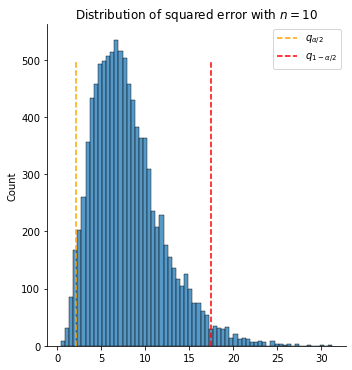

In [178]:
proba = squared_error_interval(
    beta= np.array([0,1]),
    sigma = 0.1,
)

print(f"P(error is in Int({n})) = {np.sum(proba)/ len(proba)}")


P(error is in Int(10)) = 0.9494


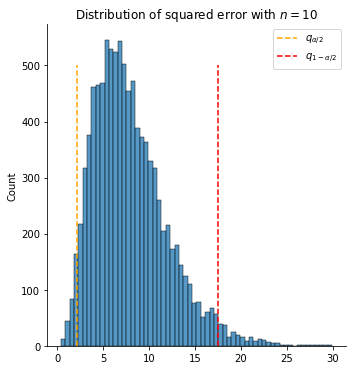

In [179]:
proba = squared_error_interval(
    beta= np.array([1,0]),
    sigma = 0.1,
)

print(f"P(error is in Int({n})) = {np.sum(proba)/ len(proba)}")


P(error is in Int(10)) = 0.9532


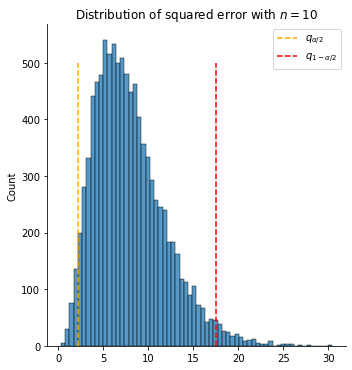

In [180]:
proba = squared_error_interval(
    beta= np.array([1,2]),
    sigma = 0.1,
)

print(f"P(error is in Int({n})) = {np.sum(proba)/ len(proba)}")
